## 110062592 姜宏昀
這次我的evaluate的方法是用accuracy來判斷，因為這次的功課y值只有0/1，如果用mse之類的來判斷可能會不太合適

我大致上試了
* tensorflow neural network
* random forest
* LogisticRegression
* RidgeClassifier

除了tensorflow network 有發生overfitting的現象，其餘的好像都沒有


| Method | Train Acc | Val Acc |
| -------- | -------- | -------- |
| tf classifier     | 0.607     | 0.606    |
| random forest     | 0.61    | 0.61    |
| LogisticRegression| 0.60    | 0.60    |
| RidgeClassifier| 0.60    | 0.60    |

準確率都卡在0.6不知道怎麼再提升上去，後面random forest, LogisticRegression, RidgeClassifier 好像都沒有很好的fit到資料
nn 有fit資料且達到overfitting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
X_train = pd.read_csv('./data/X_train.csv')
Y_train = pd.read_csv('./data/y_train.csv')

x_test = pd.read_csv('./data/X_test.csv')
x_test.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,3,595,11.3,1,1.8,3.9,2,0.3
1,2,530,11.0,0,1.0,24.3,3,6.3
2,1,221,21.3,2,1.9,3.5,2,11.5
3,3,442,9.0,0,0.6,2.4,2,3.4
4,1,634,16.1,0,0.8,4.2,2,1.6


In [3]:
print(X_train.shape)
print(Y_train.columns)
print(X_train.columns)

(85751, 8)
Index(['FGM'], dtype='object')
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')


In [4]:
X_train.head()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9



我選擇的top-3 features 分別是 GAME_CLOCK, SHOT_CLOCK, SHOT_DIST 
是根據feature selection來選擇

In [5]:
# choose 3 features
selected_features = list(X_train.columns)
print(selected_features)
selected_features = ['GAME_CLOCK', 'SHOT_CLOCK', 'SHOT_DIST']
x_train_selected = X_train[selected_features]
x_test = x_test[selected_features]
x_train_selected.head()



['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST']


,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST
0,358,2.4,20.6
1,585,8.3,3.0
2,540,19.9,3.5
3,392,9.0,21.1
4,401,22.7,4.1


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_selected.values, Y_train.values, test_size=0.3, random_state=0)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(60025, 3) (60025, 1)
(25726, 3) (25726, 1)


## Normalize


In [7]:
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

x = np.vstack((x_train, x_val))
y = np.hstack((y_train, y_val))
print(x.shape, y.shape)


(85751, 3) (85751,)


In [8]:
sc = StandardScaler()
sc.fit(x)
x_train = sc.transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape)



(60025, 3) (60025,)
(25726, 3) (25726,)
(36751, 3)


In [9]:
print(x_train.shape, y_train.shape, y_train.sum() / len(y_train))
print(x_val.shape, y_val.shape, y_val.sum() / len(y_val))
print(x.shape, y.shape)
print(x_test.shape)

(60025, 3) (60025,) 0.451695127030404
(25726, 3) (25726,) 0.45856332115369663
(85751, 3) (85751,)
(36751, 3)


## Feature Selection

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(x_train, y_train)

y_pred = forest.predict(x_val)
print('Accuracy (forest): %.2f' % accuracy_score(y_val, y_pred))

Accuracy (forest): 0.60


In [43]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_train.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) GAME_CLOCK                     0.204639
 2) SHOT_DIST                      0.195848
 3) SHOT_CLOCK                     0.187627
 4) CLOSE_DEF_DIST                 0.168901
 5) TOUCH_TIME                     0.139810
 6) PERIOD                         0.050858
 7) DRIBBLES                       0.046158
 8) PTS_TYPE                       0.006159


In [44]:
from sklearn.feature_selection import SelectFromModel
# put prefitted RandomForestClassifier "forest" into SelectFromModel
sfm = SelectFromModel(forest, threshold=0.16, prefit=True)
Z_forest_alt = sfm.transform(X_train)

for f in range(Z_forest_alt.shape[1]): #mdf
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X_train.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) GAME_CLOCK                     0.204639
 2) SHOT_DIST                      0.195848
 3) SHOT_CLOCK                     0.187627
 4) CLOSE_DEF_DIST                 0.168901


In [14]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression

In [15]:
def get_acc(pred, ans):
    assert len(pred) == len(ans)
    return sum(1 for x,y in zip(pred, ans) if x == y) / len(ans)

## Try to use tensorflow

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam, SGD


In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
#     plt.xticks(np.arange(0,50,5))
    plt.legend()
    plt.grid(True)

C:\Users\hongyun\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


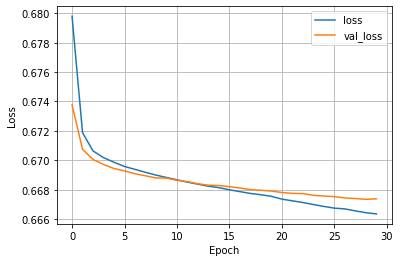

In [12]:
model = keras.Sequential([
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    verbose=0, 
    batch_size=1024,
    epochs=30,
    shuffle=True,
)


plot_loss(history)


### 上圖在約第15 epoch 之後發生了overfitting training loss 持續下降，但是validate loss 沒有下降 且比 training loss還要高

In [16]:
y_val_pred = model.predict(x_val, batch_size=1024, verbose=0)
y_val_pred = np.squeeze(y_val_pred)
y_val_pred = np.where(y_val_pred > 0.5, 1, 0)
print(f'val final acc = {get_acc(y_val_pred, y_val)}')

y_train_pred = model.predict(x_train, batch_size=1024, verbose=0)
y_train_pred = np.squeeze(y_train_pred)
y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
print(f'train final acc = {get_acc(y_train_pred, y_train)}')

val final acc = 0.6064681645028376
train final acc = 0.6072636401499375


In [18]:
y_pred = model.predict(x_test, batch_size=1024, verbose=0)
y_pred = np.squeeze(y_pred)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(y_pred.sum(), y_pred.sum()/len(y_pred))
np.savetxt("y_pred.csv", y_pred, delimiter=",")

11332 0.3083453511469076


In [54]:
from sklearn.model_selection import learning_curve

def draw_learning_curve(estimator, scoring, x, y, title):
#     poly = PolynomialFeatures(degree=d)
#     X = poly.fit_transform(x[:,np.newaxis])

#     lr = LinearRegression()
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=x, y=y, scoring=scoring)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='Training acc')
    plt.fill_between(train_sizes,
        train_mean+train_std,
        train_mean-train_std,
        alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation acc')
    plt.fill_between(train_sizes,
        test_mean+test_std,
        test_mean-test_std,
        alpha=0.15, color='green')

#     plt.hlines(y=y, xmin=0, xmax=80, color='red', linewidth=2, linestyle='--')

    plt.title(title)
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel(scoring)
    plt.legend(loc='upper right')
#     plt.xticks(np.arange(0,,5000))

#     plt.ylim([0, 3])
#     plt.tight_layout()
#     plt.savefig('./output/fig-learning-curve-%d.png' % d, dpi=300)
    plt.show()

## Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

### 這邊觀察accuracy 來看是沒有發生 overfitting的 
* 這邊我是選擇用accuracy來判斷 有沒有發生overfitting
* Training acc 是持續下降的，沒有一直上升
* val acc 也持續上升 沒有overfitting的現象

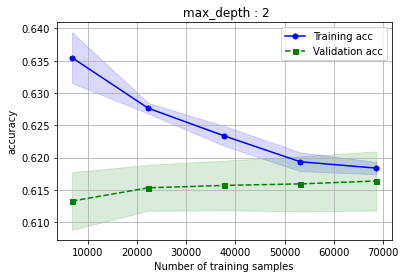

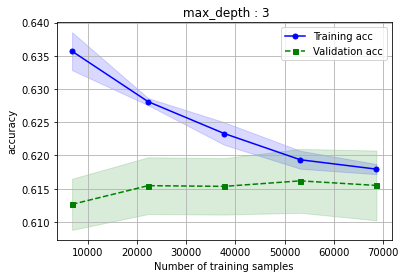

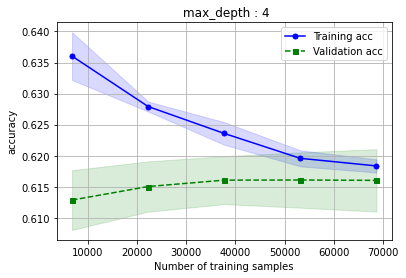

In [56]:
for max_depth in [2,3,4]:
    title = f' max_depth : {max_depth}'
    model = RandomForestClassifier(max_depth=5)
    draw_learning_curve(model, 'accuracy', x, y, title)

In [41]:
model = RandomForestClassifier(max_depth=2)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

print(y_train_pred.sum())
print(y_val_pred.sum())
print('acc train: %.2f, valid: %.2f' % (
                get_acc(y_train_pred, y_train),
                get_acc(y_val_pred, y_val))) 

15593
6709
acc train: 0.61, valid: 0.61


In [57]:
model = RandomForestClassifier(max_depth=2)
model.fit(x, y)
y_pred = model.predict(x_test)
y_pred.sum()
print(len(y_pred))
print(y_pred.sum()/len(y_pred))
# np.savetxt("y_pred.csv", y_pred, delimiter=",")

36751
0.9523822481020925


## LogisticRegression 

### 這邊觀察accuracy 來看是沒有發生 overfitting的 
* 這邊我是選擇用accuracy來判斷 有沒有發生overfitting
* Training acc 是持續下降的，沒有一直上升
* val acc 也持續上升 沒有overfitting的現象

c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

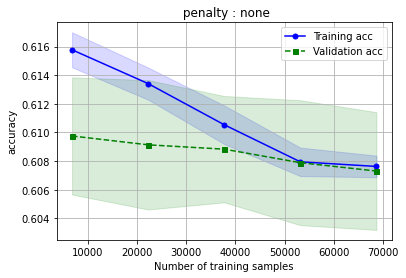

c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

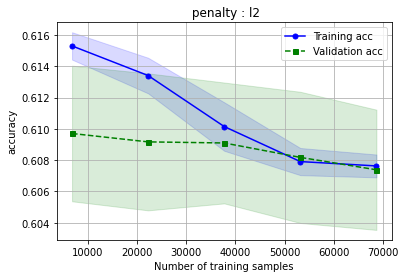

In [58]:
for penalty in ['none','l2']:
    title = f' penalty : {penalty}'
    model = LogisticRegression(penalty=penalty)
    draw_learning_curve(model, 'accuracy', x, y, title)

In [75]:
for penalty in ['none','l2']:
    model = LogisticRegression(penalty=penalty)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    print(f'penalty : {penalty}')
    print(y_val_pred.sum() / len(y_val_pred))
    print('acc train: %.2f, valid: %.2f' % (
                    get_acc(y_train_pred, y_train),
                    get_acc(y_val_pred, y_val))) 

penalty : none
0.3607634299930032
acc train: 0.61, valid: 0.61
penalty : l2
0.35998600637487366
acc train: 0.61, valid: 0.61


c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
model = LogisticRegression(penalty='none')
model.fit(x, y)
y_pred = model.predict(x_test)
print(y_pred.sum(), y_pred.sum()/ len(y_pred))
np.savetxt("y_pred.csv", y_pred, delimiter=",")
print(y_pred.sum())

18784 0.5111153438001687
18784


c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
model = LogisticRegression(penalty='none')
model.fit(x, y)
y_pred = model.predict(x_test)
y_pred.sum()
print(len(y_pred))
print(y_pred.sum())
np.savetxt("y_pred.csv", y_pred, delimiter=",")

36751
3203


## RidgeClassifier with different alpha

### 這邊觀察accuracy 來看是沒有發生 overfitting的 
* 這邊我是選擇用accuracy來判斷 有沒有發生overfitting
* Training acc 是持續下降的，沒有一直上升
* val acc 也持續上升 沒有overfitting的現象

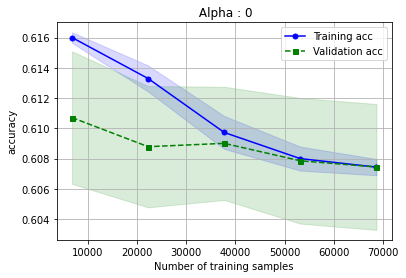

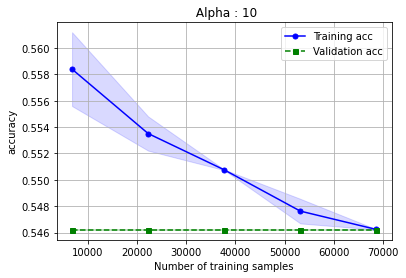

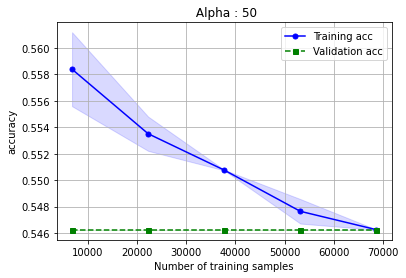

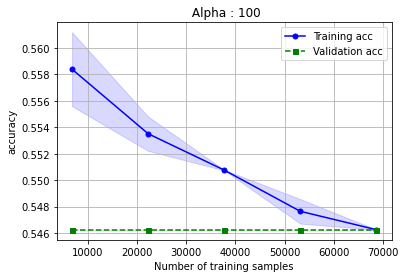

In [59]:
for alpha in [0,10,50,100]:
    title = f' Alpha : {alpha}'
    model = RidgeClassifier(alpha=alpha, normalize=True)
    draw_learning_curve(model, 'accuracy', x, y, title)

In [74]:
for alpha in [0,10,100]:

    model = RidgeClassifier(alpha=alpha, normalize=True)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    
    print(f'alpha : {alpha}')
    print('acc train: %.2f, valid: %.2f' % (
                    get_acc(y_train_pred, y_train),
                    get_acc(y_val_pred, y_val))) 

c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\users\hongyun\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


alpha : 0
acc train: 0.60, valid: 0.60
alpha : 10
acc train: 0.55, valid: 0.54
alpha : 100
acc train: 0.55, valid: 0.54
